In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, defaultdict, Counter
from itertools import product, combinations
import random

In [26]:
#assembly = '38'
#phase_dir = '../phased_spark_quads_del'
#family_id = 'SF0039088.SP0039089.SP0039088'
#ped_file = '../../DATA/spark/spark.ped.quads.ped'
#data_dir = '../../DATA/spark/genotypes'

assembly = '38'
phase_dir = '../phased_ihart.ms2_quads_del'
family_id = 'AU0028.AU002803.AU002805'
ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'
data_dir = '../../DATA/ihart.ms2/genotypes'

In [27]:
#pulls phase data from a file
def pull_phase(filename):
	with open(filename, 'r') as f:
		header = next(f).strip().split('\t')[1:-2] # skip header

		if len([x for x in header if x.endswith('_del')]) != 4:
			raise Exception('This is a complex family.')

		individuals = [x[:-4] for x in header if x.endswith('_mat')]

		if len(individuals) == 3:
			raise Exception('This is a trio.')

		states = []
		chrs = []
		starts = []
		ends = []
		for line in f:
			pieces = line.strip().split('\t')
			chrs.append(int(pieces[0][3:]))
			states.append(list(map(int, pieces[1:-2])))
			starts.append(int(pieces[-2]))
			ends.append(int(pieces[-1]))

		mat_indices = [i for i, x in enumerate(header) if x.endswith('_mat')]
		pat_indices = [i for i, x in enumerate(header) if x.endswith('_pat')]

		states = np.array(states).T
		starts = np.array(starts)
		ends = np.array(ends)

		# if this is a hard to sequences region, we don't know the exact location of crossovers
		states[:, states[-1, :]==1] = -1

		for (mat_index1, pat_index1), (mat_index2, pat_index2) in combinations(zip(mat_indices[2:], pat_indices[2:]), 2):
			no_missing_mat = (states[mat_index1, :] != -1) & (states[mat_index2, :] != -1)
			no_missing_pat = (states[pat_index1, :] != -1) & (states[pat_index2, :] != -1)

			if np.sum(((states[mat_index1, :] == states[mat_index2, :])*(ends-starts))[no_missing_mat])/np.sum((ends-starts)[no_missing_mat]) > 0.9 and \
				np.sum(((states[pat_index1, :] == states[pat_index2, :])*(ends-starts))[no_missing_pat])/np.sum((ends-starts)[no_missing_pat]) > 0.9:
				raise Exception('This family contains identical twins.')


	return states, np.array(chrs), starts, ends, individuals, mat_indices, pat_indices

states, chroms, starts, ends, individuals, mat_indices, pat_indices = pull_phase('%s/%s.phased.txt' % (phase_dir, family_id))
mult = ends-starts

In [28]:
print(chroms)

[ 1  1  1 ... 22 22 22]


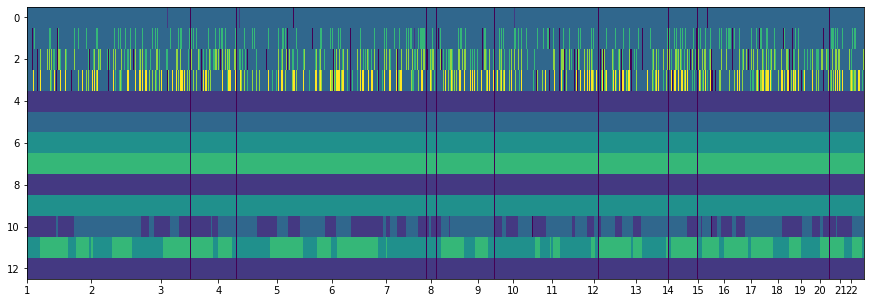

In [29]:
plt.figure(figsize=(15, 5))
plt.imshow(states, aspect='auto')
plt.xticks([0] + np.where(chroms[1:] != chroms[:-1])[0].tolist(), np.arange(1, 23))
plt.show()

In [30]:
cyto = []
centromere_starts, centromere_ends = -np.ones((23,), dtype=int), -np.ones((23,), dtype=int)

with open('../data/cytoBand%s.txt' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split('\t')
        cyto.append((pieces[0], int(pieces[1]), int(pieces[2]), pieces[3], pieces[4]))



In [31]:
# extracts all recombination points from phase
Recombination = namedtuple('Recombination', ['family', 'chrom', 'start_pos', 'end_pos', 'child', 'is_mat', 'is_pat'])
def pull_recombinations(family_id, states, chroms, starts, ends, individuals,  indices, is_mat):
    recombinations = []
    for chrom in range(1, 23):
        # block out 
        
        for individual, index in zip(individuals, indices):

            change_indices = np.where((chroms[:-1]==chrom) & (chroms[1:]==chrom) & (states[index, :-1] != states[index, 1:]))[0]+1
                        
            if change_indices.shape[0]>0:
                current_index = change_indices[0]
                for next_index in change_indices[1:]:
                    assert states[index, current_index-1] != states[index, current_index]
                    assert states[index, current_index] != states[index, next_index]

                    if states[index, current_index-1] != -1 and states[index, current_index] != -1:
                        # we know exactly where the recombination happened
                        recombinations.append(Recombination(family_id, chrom, int(ends[current_index-1])-1, int(starts[current_index]),
                                    (individual, individuals[2]), is_mat, not is_mat))
                    elif states[index, current_index-1] != -1 and states[index, current_index] == -1 and states[index, next_index] != -1 and states[index, current_index-1] != states[index, next_index]:
                        # there's a region where the recombination must have occured
                        recombinations.append(Recombination(family_id, chrom, int(ends[current_index-1])-1, int(starts[next_index]),
                                    (individual, individuals[2]), is_mat, not is_mat))
                    
                    current_index = next_index
                if states[index, current_index-1] != -1 and states[index, current_index] != -1:
                    # we know exactly where the recombination happened
                    recombinations.append(Recombination(family_id, chrom, int(ends[current_index-1])-1, int(starts[current_index]),
                                    (individual, individuals[2]), is_mat, not is_mat))

    return recombinations

mat_recombinations = pull_recombinations(family_id, states, chroms, starts, ends, individuals, mat_indices, True)
pat_recombinations = pull_recombinations(family_id, states, chroms, starts, ends, individuals, pat_indices, False)
recombinations = mat_recombinations + pat_recombinations

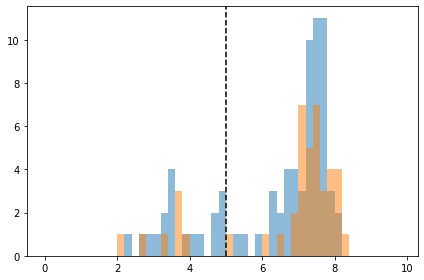

In [32]:
mat_dists, pat_dists = [], []
for individual in individuals:
    for chrom in range(1, 23):
        rs = sorted([r for r in recombinations if r.child==(individual, individuals[2]) and r.chrom == chrom and r.is_mat], key=lambda x: x.start_pos)
        mat_dists.extend([np.mean([r2.start_pos, r2.end_pos]) - np.mean([r1.start_pos, r1.end_pos]) for r1, r2 in zip(rs[:-1], rs[1:])])

        rs = sorted([r for r in recombinations if r.child==(individual, individuals[2]) and r.chrom == chrom and r.is_pat], key=lambda x: x.start_pos)
        pat_dists.extend([np.mean([r2.start_pos, r2.end_pos]) - np.mean([r1.start_pos, r1.end_pos]) for r1, r2 in zip(rs[:-1], rs[1:])])


plt.hist(np.log10(mat_dists), bins=np.arange(0, 10, 0.2), alpha=0.5)
plt.hist(np.log10(pat_dists), bins=np.arange(0, 10, 0.2), alpha=0.5)
plt.axvline(np.log10(100000), color='black', linestyle='--')

plt.tight_layout()
plt.show()


In [33]:
Crossover = namedtuple('Crossover', ['family', 'chrom', 'start_pos', 'end_pos', 'child', 'is_mat', 'is_pat', 'is_complex', 'recombinations'])
GeneConversion = namedtuple('GeneConversion', ['family', 'chrom', 'start_pos', 'end_pos', 'child', 'is_mat', 'is_pat', 'is_complex', 'recombinations'])

def match_recombinations(recombinations, chrom, child, is_mat):
    gene_conversions = []
    crossovers = []
    
    rs = [r for r in recombinations if r.chrom==chrom and r.child==child and r.is_mat==is_mat]
    dists = np.array([r2.start_pos-r1.end_pos for r1, r2 in zip(rs[:-1], rs[1:])])
    breaks = [0] + (np.where(dists>100000)[0]+1).tolist() + [len(rs)]
    for break_start, break_end in zip(breaks[:-1], breaks[1:]):
        r_group = rs[break_start:break_end]
        if len(r_group)>0:
        
            if len(r_group)%2 == 0:
                gene_conversions.append(GeneConversion(family_id, chrom, 
                                                       r_group[0].start_pos, r_group[-1].end_pos, child,
                                                       is_mat, not is_mat, len(r_group)>2, tuple(r_group)))
            else:
                crossovers.append(Crossover(family_id, chrom,
                                           r_group[0].start_pos, r_group[-1].end_pos, child,
                                           is_mat, not is_mat, len(r_group)>1, tuple(r_group)))

    return gene_conversions, crossovers

gene_conversions, crossovers = [], []
children = set([x.child for x in recombinations])
for chrom in range(1, 23):
    for child in children:
        gc, co = match_recombinations(recombinations, chrom, child, True)
        gene_conversions.extend(gc)
        crossovers.extend(co)
        
        gc, co = match_recombinations(recombinations, chrom, child, False)
        gene_conversions.extend(gc)
        crossovers.extend(co)

print('gc', len(gene_conversions), 'co', len(crossovers))


gc 26 co 108


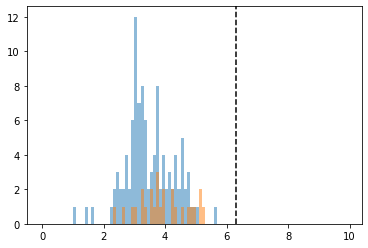

In [34]:
plt.hist([np.log10(r.end_pos-r.start_pos) for r in crossovers], alpha=0.5, bins=np.arange(0, 10, 0.1))
plt.hist([np.log10(r.end_pos-r.start_pos) for r in gene_conversions], alpha=0.5, bins=np.arange(0, 10, 0.1))
plt.axvline(np.log10(2000000), color='black', linestyle='--')
plt.show()

In [35]:
def remove_massive_events(gene_conversions, crossovers):
    # remove events that span too large an area
    gene_conversions = [gc for gc in gene_conversions if gc.end_pos-gc.start_pos<2000000]
    #crossovers = [co for co in crossovers if co.end_pos-co.start_pos<2000000]

    print('after removing events that span more than 2MB')
    print('gc', len(gene_conversions), 'co', len(crossovers))
    
    return gene_conversions, crossovers
    

#gene_conversions, crossovers = remove_massive_events(gene_conversions, crossovers)

In [36]:
def move_identical(family, gene_conversions, crossovers):
    if len(family)>4:
        # gene conversions
        gc_to_overlapping = dict([(x, {x}) for x in gene_conversions])
        for gc1, gc2 in combinations(gene_conversions, 2):
            if gc1.child != gc2.child and gc1.chrom == gc2.chrom and min(gc1.end_pos, gc2.end_pos)-max(gc1.start_pos, gc2.start_pos)>0: 
                gc_to_overlapping[gc1].add(gc2)
                gc_to_overlapping[gc2].add(gc1)

        to_be_added = []
        to_be_removed = set()
        for key, gc_group in gc_to_overlapping.items():
            if set(sum([list(x.child) for x in gc_group], [])) == set(individuals[2:]):
                to_be_added.append(GeneConversion(key.family, key.chrom, 
                                                  min([gc.start_pos for gc in gc_group]), max([gc.end_pos for gc in gc_group]),
                                                  individuals[2], key.is_mat, key.is_pat, key.is_complex, 
                                                  tuple(sum([list(gc.recombinations) for gc in gc_group], []))))
                to_be_removed.update(gc_group)


        for c in to_be_removed:
            gene_conversions.remove(c)
        gene_conversions = [GeneConversion(gc.family, gc.chrom, gc.start_pos, gc.end_pos,
                                          gc.child[0], gc.is_mat, gc.is_pat, gc.is_complex, gc.recombinations) for gc in gene_conversions]
        gene_conversions.extend(to_be_added)
        print('gene conversions transferred to child1', len(to_be_added))

        # recombinations
        co_to_overlapping = dict([(x, {x}) for x in crossovers])
        for gc1, gc2 in combinations(crossovers, 2):
            if gc1.child != gc2.child and gc1.chrom == gc2.chrom and min(gc1.end_pos, gc2.end_pos)-max(gc1.start_pos, gc2.start_pos)>0: 
                co_to_overlapping[gc1].add(gc2)
                co_to_overlapping[gc2].add(gc1)

        to_be_added = []
        to_be_removed = set()
        for key, gc_group in co_to_overlapping.items():
            if set(sum([list(x.child) for x in gc_group], [])) == set(individuals[2:]):
                to_be_added.append(Crossover(key.family, key.chrom, 
                                                  min([gc.start_pos for gc in gc_group]), max([gc.end_pos for gc in gc_group]),
                                                  individuals[2], key.is_mat, key.is_pat, key.is_complex, 
                                                  tuple(sum([list(gc.recombinations) for gc in gc_group], []))))
                to_be_removed.update(gc_group)


        for c in to_be_removed:
            crossovers.remove(c)
        crossovers = [Crossover(co.family, co.chrom, co.start_pos, co.end_pos,
                                          co.child[0], co.is_mat, co.is_pat, co.is_complex, co.recombinations) for co in crossovers]
        crossovers.extend(to_be_added)
        print('crossovers transferred to child1', len(to_be_added))
    return gene_conversions, crossovers

#gene_conversions, crossovers = move_identical(individuals, gene_conversions, crossovers)


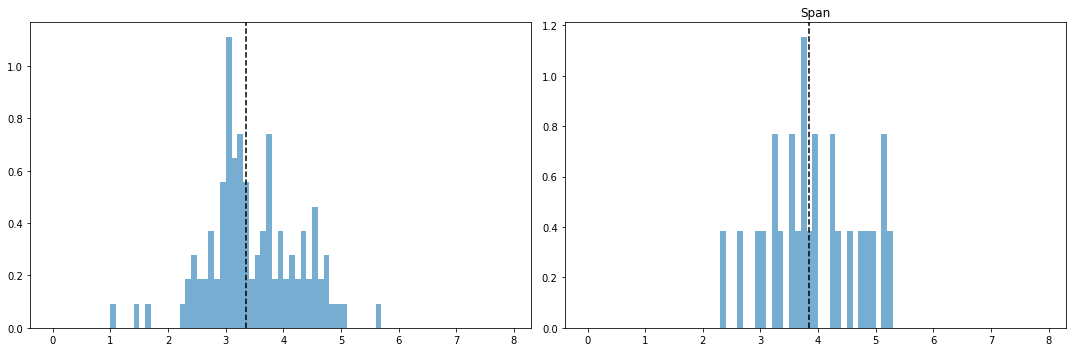

In [37]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(np.log10([r.end_pos-r.start_pos for r in crossovers]), 
         bins=np.arange(0, 8, 0.1), alpha=0.6, density=True)
plt.axvline(np.log10(np.median([r.end_pos-r.start_pos for r in crossovers])), color='black', linestyle='--')
plt.subplot(1, 2, 2)
plt.hist(np.log10([r.end_pos-r.start_pos for r in gene_conversions]), 
         bins=np.arange(0, 8, 0.1), alpha=0.6, density=True)
plt.axvline(np.log10(np.median([r.end_pos-r.start_pos for r in gene_conversions])), color='black', linestyle='--')
plt.title('Span')

plt.tight_layout()
plt.show()

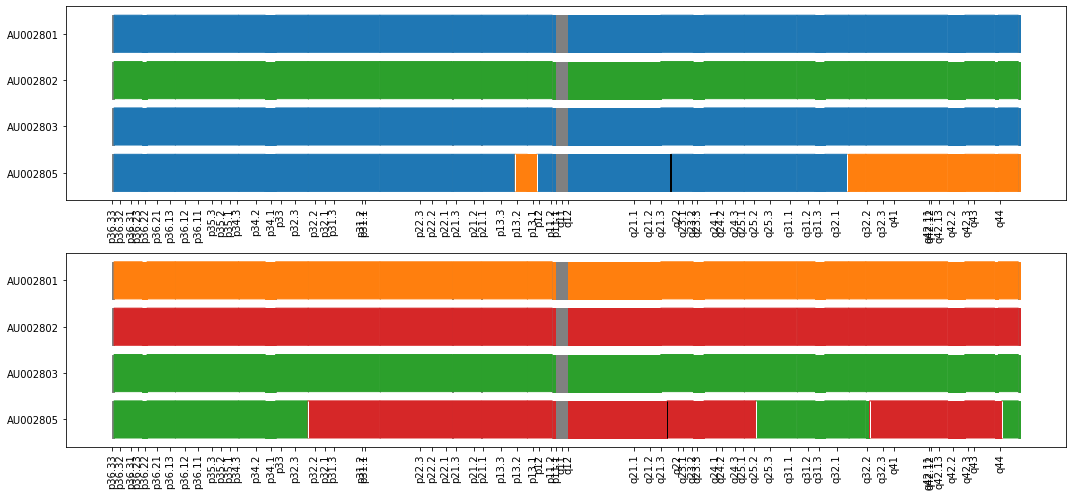

In [41]:
chrom = 1
            
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors[-1] = 'grey'


plt.figure(figsize=(15, 7))
ax = plt.subplot(2, 1, 1)
for i, (individual, j) in enumerate(zip(individuals, mat_indices)):    
    a = np.zeros((2*np.sum([chroms==chrom]),), dtype=int)
    b = np.zeros((2*np.sum([chroms==chrom]),), dtype=float)
    a[0::2] = starts[chroms==chrom]
    a[1::2] = ends[chroms==chrom]
    b[0::2] = states[j, chroms==chrom]
    b[1::2] = states[j, chroms==chrom]

    for m in np.unique(b).astype(int):
        c = np.zeros((a.shape[0],), dtype=float)
        c[b==m] = -i
        c[b!=m] = np.nan
        plt.fill_between(a, c-0.4, c+0.4, color=colors[m])
        
    for r in crossovers:
        if (r.child == (individual, individuals[2]) or r.child==individual) and r.chrom == chrom and r.is_mat:
            plt.fill_between([r.start_pos, r.end_pos], -i-0.4, -i+0.4, color='white')
    for gc in gene_conversions:
        if (gc.child == (individual, individuals[2]) or gc.child==individual) and gc.chrom == chrom and gc.is_mat:
            plt.fill_between([gc.start_pos, gc.end_pos], -i-0.4, -i+0.4, color='black')
            
plt.yticks(np.arange(0, -len(individuals), -1), individuals)
plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [x[2] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)

plt.subplot(2, 1, 2, sharex=ax)
for i, (individual, j) in enumerate(zip(individuals, pat_indices)):    
    a = np.zeros((2*np.sum([chroms==chrom]),), dtype=int)
    b = np.zeros((2*np.sum([chroms==chrom]),), dtype=float)
    a[0::2] = starts[chroms==chrom]
    a[1::2] = ends[chroms==chrom]
    b[0::2] = states[j, chroms==chrom]
    b[1::2] = states[j, chroms==chrom]

    for m in np.unique(b).astype(int):
        c = np.zeros((a.shape[0],), dtype=float)
        c[b==m] = -i
        c[b!=m] = np.nan
        plt.fill_between(a, c-0.4, c+0.4, color=colors[m])
        
    for r in crossovers:
        if (r.child == (individual, individuals[2]) or r.child==individual) and r.chrom == chrom and r.is_pat:
            plt.fill_between([r.start_pos, r.end_pos], -i-0.4, -i+0.4, color='white')
    for gc in gene_conversions:
        if (gc.child == (individual, individuals[2]) or gc.child==individual) and gc.chrom == chrom and gc.is_pat:
            plt.fill_between([gc.start_pos, gc.end_pos], -i-0.4, -i+0.4, color='black')
plt.yticks(np.arange(0, -len(individuals), -1), individuals)
plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)

#plt.xlim([120000000, 130000000])
#print([(r, gc) for r, gc in zip(recombinations, is_gene_conversion) if r.chrom == chrom and r.start_pos>=820000 and r.end_pos<=840000])
plt.tight_layout()
plt.show()

In [42]:
print('GC')
gc = len(gene_conversions)/(len(individuals)-2)
gc_mat = len([c for c in gene_conversions if c.is_mat])/(len(individuals)-2)
gc_pat = len([c for c in gene_conversions if c.is_pat])/(len(individuals)-2)
print('avg per child', gc)
print('avg mat per child', gc_mat)
print('avg pat per child', gc_pat)

print('\ncrossovers')
cr = len(crossovers)/(len(individuals)-2)
cr_mat = len([c for c in crossovers if c.is_mat])/(len(individuals)-2)
cr_pat = len([c for c in crossovers if c.is_pat])/(len(individuals)-2)
print('avg per child', cr)
print('avg mat per child', cr_mat)
print('avg pat per child', cr_pat)
print('\navg GC/crossover', gc/cr)
print('avg GC/crossover mat', gc_mat/cr_mat)
print('avg GC/crossover pat', gc_pat/cr_pat)


GC
avg per child 13.0
avg mat per child 9.0
avg pat per child 4.0

crossovers
avg per child 54.0
avg mat per child 29.5
avg pat per child 24.5

avg GC/crossover 0.24074074074074073
avg GC/crossover mat 0.3050847457627119
avg GC/crossover pat 0.16326530612244897


In [43]:
for ind in individuals:
    print(ind, 
          len([x for x in gene_conversions if x.child==(ind, individuals[2])]),
          len([x for x in crossovers if x.child==(ind, individuals[2])]),
          len([x for x in gene_conversions if x.child==(ind, individuals[2]) and x.is_mat]),
          len([x for x in gene_conversions if x.child==(ind, individuals[2]) and x.is_pat]),
          len([x for x in crossovers if x.child==(ind, individuals[2]) and x.is_mat]),
          len([x for x in crossovers if x.child==(ind, individuals[2]) and x.is_pat]))

AU002801 0 0 0 0 0 0
AU002802 0 0 0 0 0 0
AU002803 0 0 0 0 0 0
AU002805 26 108 18 8 59 49


# Look at COs and NCOs

In [22]:
import importlib.util
spec = importlib.util.spec_from_file_location("input_output", "../phase/input_output.py")
input_output = importlib.util.module_from_spec(spec)
spec.loader.exec_module(input_output)
genotypes, snp_positions, mult_factor = input_output.pull_gen_data_for_individuals(data_dir, [0.5], assembly, str(chrom), individuals)



1 1 1
af_boundaries [0.5]
(4, 10126) (10126,) (10126,) (10127,)
(4, 10126) (10126,)
0
genotypes pulled (5, 20252)


In [23]:
print(len([x for x in gene_conversions if x.chrom == chrom and not x.is_complex]))
co = random.choice([x for x in gene_conversions if x.chrom == chrom and not x.is_complex])
print(co.start_pos, co.end_pos, co.is_complex, co.end_pos - co.start_pos, co.is_mat)
indices = (snp_positions[:, 1] >= co.start_pos-1000) & (snp_positions[:, 1] <= co.end_pos+1000)
print(np.sum(indices))

0


IndexError: Cannot choose from an empty sequence

In [59]:
states_segment = np.zeros((states.shape[0], np.sum(indices)), dtype=int)
for i, pos in enumerate(snp_positions[indices, 1]):
    states_segment[:, i] = states[:, (chroms==chrom) & (pos>=starts) & (pos<ends)].flatten()
    
    

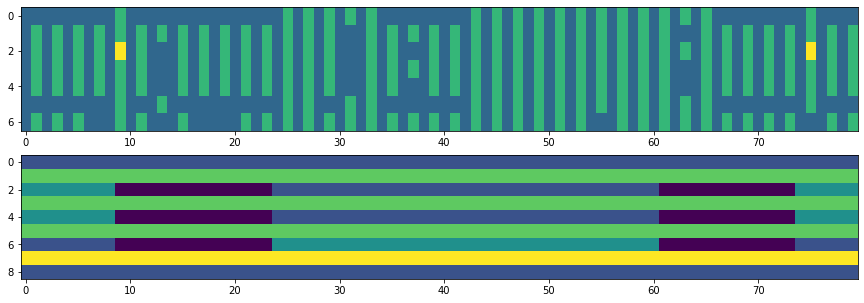

In [60]:
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.imshow(genotypes[:, indices], aspect='auto', vmin=-1, vmax=2)
plt.subplot(2, 1, 2)
plt.imshow(states_segment[8:, :], aspect='auto', vmin=-1, vmax=3)

plt.show()

# Rework states

In [24]:
new_states = states.copy()
for chrom in range(1, 23):
    #child1_mat = sorted([r for r in crossovers if r.child==individuals[2] and r.is_mat], key=lambda x: (x.chrom, x.start_pos))
    
    chrom_start, chrom_end = np.min(starts[chrom==chrom]), np.max(ends[chrom==chrom])
    
    for individual, mat_index, pat_index in zip(individuals[2:], mat_indices[2:], pat_indices[2:]):
        # ----------- maternal ---------------
        current_pos = chrom_start
        current_state = states[mat_index, 0]
        state_options = [0, 1]
        toggle_state = lambda x: -1 if x==-1 else state_options[0] if state_options[1] == x else state_options[1]
            
        for r in sorted([r for r in crossovers if r.child==individual and r.is_mat and r.chrom==chrom], key=lambda x: x.start_pos):
            new_states[mat_index, (chroms==chrom) & (starts>=current_pos) & (starts<=r.start_pos)] = current_state
            current_pos = r.end_pos
            current_state = toggle_state(current_state)
        new_states[mat_index, (chroms==chrom) & (starts>=current_pos) & (starts<=chrom_end)] = current_state
               
        # may need to toggle states if we got them backwards
        has_data = (states[mat_index, :] != -1) & (states[mat_indices[2], :] != -1) & (chroms==chrom)
        old_state_share = np.sum((states[mat_index, has_data] == states[mat_indices[2], has_data])*mult[has_data])/np.sum(mult[has_data])

        has_data = (new_states[mat_index, :] != -1) & (new_states[mat_indices[2], :] != -1) & (chroms==chrom)
        new_state_share = np.sum((new_states[mat_index, has_data] == new_states[mat_indices[2], has_data])*mult[has_data])/np.sum(mult[has_data])

        if np.abs(old_state_share-new_state_share) > np.abs(old_state_share-(1-new_state_share)):
            new_states[mat_index, chroms==chrom] = [toggle_state(x) for x in new_states[mat_index, chroms==chrom]]

        
        current_pos = chrom_start
        current_state = states[pat_index, 0]
        state_options = [2, 3]
        toggle_state = lambda x: -1 if x==-1 else state_options[0] if state_options[1] == x else state_options[1]
            
        for r in sorted([r for r in crossovers if r.child==individual and r.is_pat and r.chrom==chrom], key=lambda x: x.start_pos):
            new_states[pat_index, (chroms==chrom) & (starts>=current_pos) & (starts<=r.start_pos)] = current_state
            current_pos = r.end_pos
            current_state = toggle_state(current_state)
        new_states[pat_index, (chroms==chrom) & (starts>=current_pos) & (starts<=chrom_end)] = current_state
        
        # may need to toggle states if we got them backwards
        has_data = (states[pat_index, :] != -1) & (states[pat_indices[2], :] != -1) & (chroms==chrom)
        old_state_share = np.sum((states[pat_index, has_data] == states[pat_indices[2], has_data])*mult[has_data])/np.sum(mult[has_data])

        has_data = (new_states[pat_index, :] != -1) & (new_states[pat_indices[2], :] != -1) & (chroms==chrom)
        new_state_share = np.sum((new_states[pat_index, has_data] == new_states[pat_indices[2], has_data])*mult[has_data])/np.sum(mult[has_data])

        if np.abs(old_state_share-new_state_share) > np.abs(old_state_share-(1-new_state_share)):
            new_states[pat_index, chroms==chrom] = [toggle_state(x) for x in new_states[pat_index, chroms==chrom]]
        

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in long_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in long_scalars


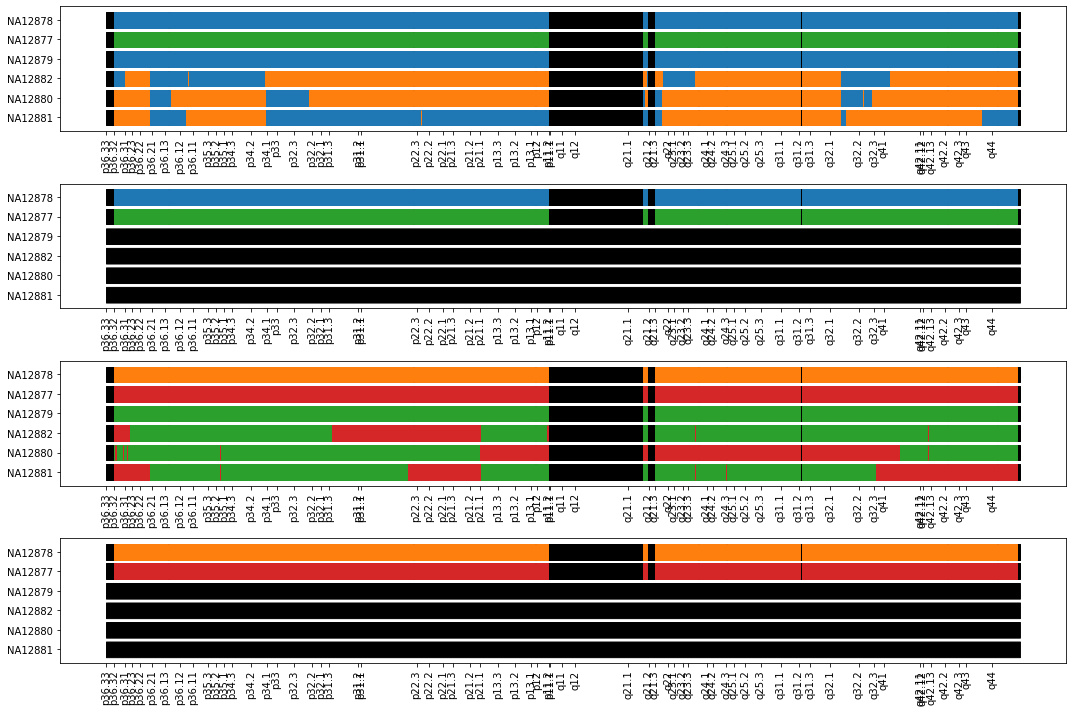

In [25]:
chrom = 1

cyto = []
with open('../data/cytoBand%s.txt' % assembly, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0] == 'chr%d'%chrom:
            cyto.append((int(pieces[1]), int(pieces[2]), pieces[3]))
            
            prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors[-1] = 'black'


plt.figure(figsize=(15, 10))
ax = plt.subplot(4, 1, 1)
for i, (individual, j) in enumerate(zip(individuals, mat_indices)):    
    a = np.zeros((2*np.sum([chroms==chrom]),), dtype=int)
    b = np.zeros((2*np.sum([chroms==chrom]),), dtype=float)
    a[0::2] = starts[chroms==chrom]
    a[1::2] = ends[chroms==chrom]
    b[0::2] = states[j, chroms==chrom]
    b[1::2] = states[j, chroms==chrom]

    for m in np.unique(b).astype(int):
        c = np.zeros((a.shape[0],), dtype=float)
        c[b==m] = -i
        c[b!=m] = np.nan
        plt.fill_between(a, c-0.4, c+0.4, color=colors[m])
        
    for r in crossovers:
        if r.child == individual and r.chrom == chrom and r.is_mat:
            plt.fill_between([r.start_pos, r.end_pos], -i-0.4, -i+0.4, color='white')
            
plt.yticks(np.arange(0, -len(individuals), -1), individuals)
plt.xticks([x[0] for x in cyto], [x[2] for x in cyto], rotation=90)

plt.subplot(4, 1, 3, sharex=ax)
for i, (individual, j) in enumerate(zip(individuals, pat_indices)):    
    a = np.zeros((2*np.sum([chroms==chrom]),), dtype=int)
    b = np.zeros((2*np.sum([chroms==chrom]),), dtype=float)
    a[0::2] = starts[chroms==chrom]
    a[1::2] = ends[chroms==chrom]
    b[0::2] = states[j, chroms==chrom]
    b[1::2] = states[j, chroms==chrom]

    for m in np.unique(b).astype(int):
        c = np.zeros((a.shape[0],), dtype=float)
        c[b==m] = -i
        c[b!=m] = np.nan
        plt.fill_between(a, c-0.4, c+0.4, color=colors[m])
        
    for r in crossovers:
        if r.child == individual and r.chrom == chrom and r.is_pat:
            plt.fill_between([r.start_pos, r.end_pos], -i-0.4, -i+0.4, color='white')
plt.yticks(np.arange(0, -len(individuals), -1), individuals)
plt.xticks([x[0] for x in cyto], [x[2] for x in cyto], rotation=90)

plt.subplot(4, 1, 2)
for i, (individual, j) in enumerate(zip(individuals, mat_indices)):    
    a = np.zeros((2*np.sum([chroms==chrom]),), dtype=int)
    b = np.zeros((2*np.sum([chroms==chrom]),), dtype=float)
    a[0::2] = starts[chroms==chrom]
    a[1::2] = ends[chroms==chrom]
    b[0::2] = new_states[j, chroms==chrom]
    b[1::2] = new_states[j, chroms==chrom]

    for m in np.unique(b).astype(int):
        c = np.zeros((a.shape[0],), dtype=float)
        c[b==m] = -i
        c[b!=m] = np.nan
        plt.fill_between(a, c-0.4, c+0.4, color=colors[m])
        
    for r in crossovers:
        if r.child == individual and r.chrom == chrom and r.is_mat:
            plt.fill_between([r.start_pos, r.end_pos], -i-0.4, -i+0.4, color='white')
            
plt.yticks(np.arange(0, -len(individuals), -1), individuals)
plt.xticks([x[0] for x in cyto], [x[2] for x in cyto], rotation=90)

plt.subplot(4, 1, 4, sharex=ax)
for i, (individual, j) in enumerate(zip(individuals, pat_indices)):    
    a = np.zeros((2*np.sum([chroms==chrom]),), dtype=int)
    b = np.zeros((2*np.sum([chroms==chrom]),), dtype=float)
    a[0::2] = starts[chroms==chrom]
    a[1::2] = ends[chroms==chrom]
    b[0::2] = new_states[j, chroms==chrom]
    b[1::2] = new_states[j, chroms==chrom]

    for m in np.unique(b).astype(int):
        c = np.zeros((a.shape[0],), dtype=float)
        c[b==m] = -i
        c[b!=m] = np.nan
        plt.fill_between(a, c-0.4, c+0.4, color=colors[m])
        
    for r in crossovers:
        if r.child == individual and r.chrom == chrom and r.is_pat:
            plt.fill_between([r.start_pos, r.end_pos], -i-0.4, -i+0.4, color='white')
plt.yticks(np.arange(0, -len(individuals), -1), individuals)
plt.xticks([x[0] for x in cyto], [x[2] for x in cyto], rotation=90)

#plt.xlim([141000000, 145000000])
#print([(r, gc) for r, gc in zip(recombinations, is_gene_conversion) if r.chrom == chrom and r.start_pos>=820000 and r.end_pos<=840000])
plt.tight_layout()
plt.show()

In [ ]:
#NA12880 145 153 94 51 94 59
#NA12881 133 157 87 46 93 64
#NA12882 130 175 84 46 106 69
#NA12883 114 186 79 35 114 72
#NA12884 97 169 58 39 94 75
#NA12885 119 172 80 39 106 66
#NA12886 174 156 117 57 91 65
#NA12887 180 164 124 56 99 65
#NA12888 153 183 108 45 114 69
#NA12893 168 166 114 54 98 68

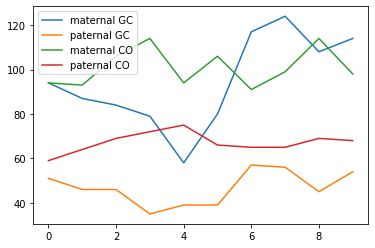

In [168]:
#plt.plot([145, 133, 130, 114, 97, 119, 174, 180, 153, 168])
#plt.plot([153, 157, 175, 186, 169, 172, 156, 164, 183, 166])
plt.plot([94, 87, 84, 79, 58, 80, 117, 124, 108, 114], label='maternal GC')
plt.plot([51, 46, 46, 35, 39, 39, 57, 56, 45, 54], label='paternal GC')
plt.plot([94, 93, 106, 114, 94, 106, 91, 99, 114, 98], label='maternal CO')
plt.plot([59, 64, 69, 72, 75, 66, 65, 65, 69, 68], label='paternal CO')
plt.legend()
plt.show()